In [1]:
import pm4py
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

In [10]:
import os
os.environ["PM4PY_NO_PROGRESS_BAR"] = "1"

# Data log

The filtered log is recreated in here as we used it for the bpmn diagram

In [2]:
file_path = '../data/BPI_Challenge_2019-3-w-after.xes'
log = pm4py.read_xes(file_path=file_path)
event_log = pm4py.convert_to_event_log(log)
event_log_df = pm4py.convert_to_dataframe(event_log)

/Users/I570206/dev/UniMa/PMA/is515-case-group1/.venv/lib/python3.12/site-packages/pm4py/utils.py:986: UserWarning: In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.
  warnings.warn("In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.")


In [3]:
number_cases = len(event_log)

In [4]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

filtered_log = pm4py.filter_start_activities(event_log, [sa for sa, freq in start_activities.items() if freq/number_cases >= 0.05 ])
filtered_log = pm4py.filter_end_activities(filtered_log, [ea for ea, freq in end_activities.items() if freq/number_cases >= 0.05])

In [5]:
perc = 0.01
filtered_log = pm4py.filter_variants_by_coverage_percentage(filtered_log, perc)
print(len(filtered_log))

7199


In [6]:
activities = attributes_filter.get_attribute_values(event_log, "concept:name")
srm_activities = [activity for activity, _ in activities.items() if "SRM" in activity]

remove = ['SRM: Transaction Completed', 'SRM: Incomplete', 'SRM: Held']
srm_activities_filtered = [activity for activity in srm_activities if activity not in remove]
event_log_srm_filtered = attributes_filter.apply_events(event_log, srm_activities_filtered)

activities_filtered_log = pm4py.get_activity_labels(filtered_log)
all_activities = srm_activities_filtered + activities_filtered_log

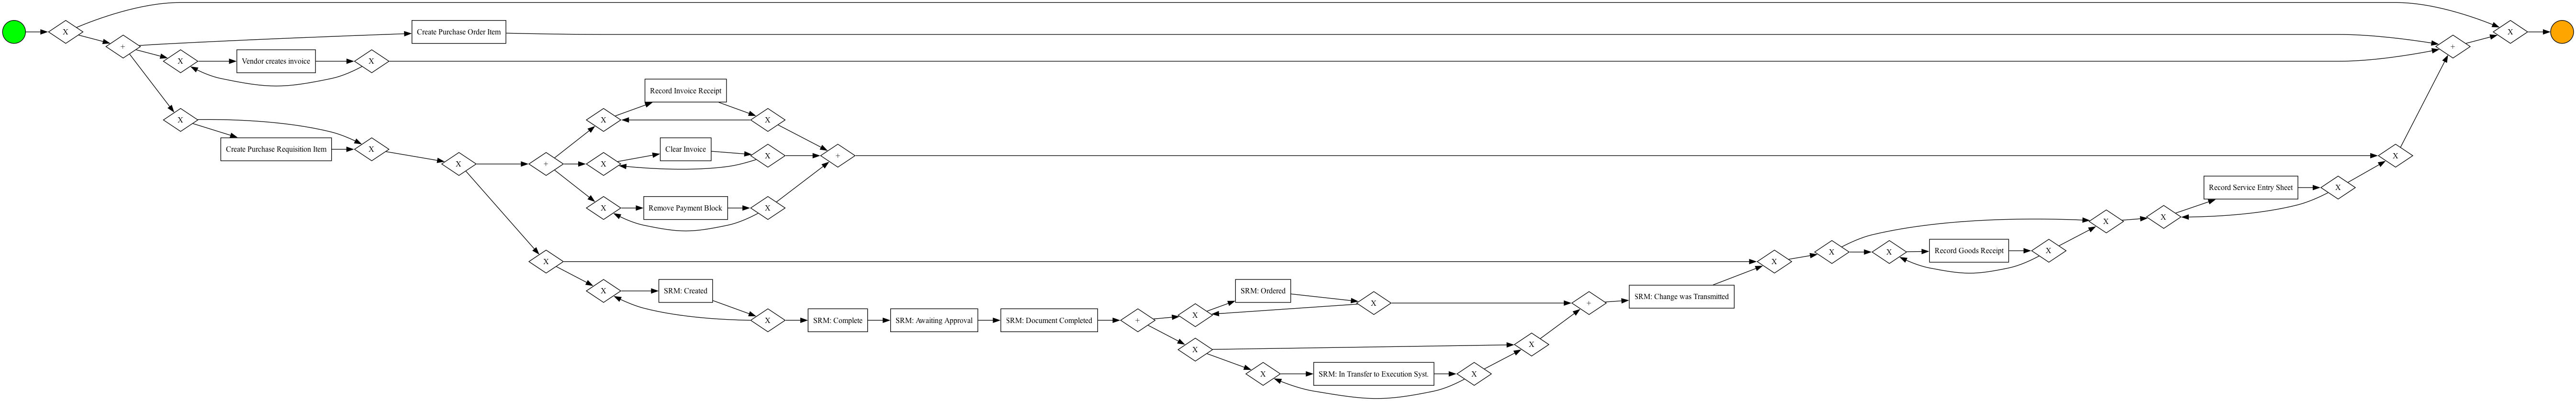

In [7]:
remove = ["Change Price", "Change Quantity"]
all_activities_filtered = [activity for activity in all_activities if activity not in remove]

log_srm_filtered = attributes_filter.apply_events(
    log=event_log,
    values=all_activities_filtered,
    parameters={"attribute_key": "concept:name"}
)
net_srm_fil, im_srm_fil, fm_srm_fil = pm4py.discover_petri_net_inductive(log_srm_filtered, noise_threshold=0.3)

bpmn_model = pm4py.discover_bpmn_inductive(log_srm_filtered, noise_threshold=0.3)
pm4py.view_bpmn(bpmn_model)

# Conformance Checking

We check the conformance for our to be and our as is process on the filtered log as well as on the enitre given log.

## to be Process

In [8]:
bpmn_model = pm4py.read_bpmn("bpnm/Purchase-2-Pay-CaseStudy-tobe.bpmn")
tb_net, tb_im, tb_fm = pm4py.convert_to_petri_net(bpmn_model)

### filtered log

In [11]:
alignment_results = alignments.apply_log(log_srm_filtered, tb_net, tb_im, tb_fm)
print(alignment_results[0])

aligning log, completed variants ::   0%|          | 0/3752 [00:00<?, ?it/s]

{'alignment': [('SRM: Created', 'SRM: Created'), ('SRM: Complete', 'SRM: Complete'), ('SRM: Awaiting Approval', 'SRM: Awaiting Approval'), ('SRM: Document Completed', 'SRM: Document Completed'), ('SRM: Ordered', 'SRM: Ordered'), ('SRM: In Transfer to Execution Syst.', 'SRM: In Transfer to Execution Syst.'), ('SRM: Change was Transmitted', 'SRM: Change was Transmitted'), ('Create Purchase Order Item', '>>'), ('Vendor creates invoice', '>>'), ('Record Goods Receipt', '>>'), ('Record Service Entry Sheet', '>>'), ('Record Invoice Receipt', '>>'), ('Clear Invoice', '>>'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Transfer Failed (E.Sys.)', '>>')], 'cost': 80000, 'visited_states': 16, 'queued_states': 33, 'traversed_arcs': 33, 'lp_solved': 21, 'fitness': 0.6363636363636364, 'bwc': 220000}


In [14]:
fitness_values = [res["fitness"] for res in alignment_results]
costs = [res["cost"] for res in alignment_results]

overall_fitness = sum(fitness_values) / len(fitness_values)

print("Overall fitness:", overall_fitness)
print("Average alignment cost:", sum(costs) / len(costs))

Overall fitness: 0.026180111852392794
Average alignment cost: 271118.42971940455


In [15]:
replay_results = token_replay.apply(log_srm_filtered, tb_net, tb_im, tb_fm)

replaying log with TBR, completed traces ::   0%|          | 0/3752 [00:00<?, ?it/s]

In [16]:
def compute_tbr_fitness(replay_results):
    fitness_values = []

    for res in replay_results:
        missing = res["missing_tokens"]
        remaining = res["remaining_tokens"]
        consumed = res["consumed_tokens"]
        produced = res["produced_tokens"]

        denom = consumed + produced

        if denom == 0:
            fitness = 0
        else:
            fitness = 1 - (missing + remaining) / denom

        fitness_values.append(fitness)

    avg_fitness = sum(fitness_values) / len(fitness_values)
    return avg_fitness, fitness_values

avg_fitness, case_fitness = compute_tbr_fitness(replay_results)

print("Average replay-based fitness:", avg_fitness)

Average replay-based fitness: 0.4977421430651968


### whole log

In [17]:
alignment_results = alignments.apply_log(event_log, tb_net, tb_im, tb_fm)
print(alignment_results[0])

aligning log, completed variants ::   0%|          | 0/4228 [00:00<?, ?it/s]

{'alignment': [('SRM: Created', 'SRM: Created'), ('SRM: Complete', 'SRM: Complete'), ('SRM: Awaiting Approval', 'SRM: Awaiting Approval'), ('SRM: Document Completed', 'SRM: Document Completed'), ('SRM: Ordered', 'SRM: Ordered'), ('SRM: In Transfer to Execution Syst.', 'SRM: In Transfer to Execution Syst.'), ('SRM: Change was Transmitted', 'SRM: Change was Transmitted'), ('Create Purchase Order Item', '>>'), ('Vendor creates invoice', '>>'), ('Record Goods Receipt', '>>'), ('Record Service Entry Sheet', '>>'), ('Record Invoice Receipt', '>>'), ('Clear Invoice', '>>'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Transfer Failed (E.Sys.)', '>>')], 'cost': 80000, 'visited_states': 16, 'queued_states': 33, 'traversed_arcs': 33, 'lp_solved': 21, 'fitness': 0.6363636363636364, 'bwc': 220000}


In [18]:
fitness_values = [res["fitness"] for res in alignment_results]
costs = [res["cost"] for res in alignment_results]

overall_fitness = sum(fitness_values) / len(fitness_values)

print("Overall fitness:", overall_fitness)
print("Average alignment cost:", sum(costs) / len(costs))

Overall fitness: 0.025948227662347587
Average alignment cost: 274699.64431563695


In [19]:
replay_results = token_replay.apply(event_log, tb_net, tb_im, tb_fm)

replaying log with TBR, completed traces ::   0%|          | 0/4228 [00:00<?, ?it/s]

In [20]:
avg_fitness, case_fitness = compute_tbr_fitness(replay_results)

print("Average replay-based fitness:", avg_fitness)

Average replay-based fitness: 0.4977907015889275


## to be withou sub Process

In [22]:
bpmn_model = pm4py.read_bpmn("bpnm/CaseStudy-To-Be-Process-without-sub.bpmn")
tb_net, tb_im, tb_fm = pm4py.convert_to_petri_net(bpmn_model)

### filtered log

In [23]:
alignment_results = alignments.apply_log(log_srm_filtered, tb_net, tb_im, tb_fm)
print(alignment_results[0])

aligning log, completed variants ::   0%|          | 0/3752 [00:00<?, ?it/s]

{'alignment': [('>>', 'Create Purchase Requisition Item'), ('SRM: Created', 'SRM: Created'), ('SRM: Complete', 'SRM: Complete'), ('SRM: Awaiting Approval', 'SRM: Awaiting Approval'), ('SRM: Document Completed', 'SRM: Document Completed'), ('>>', 'SRM: In Transfer to Exec. Syst.'), ('SRM: Ordered', 'SRM: Ordered'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Change was Transmitted', 'SRM: Change was Transmitted'), ('>>', None), ('Create Purchase Order Item', 'Create Purchase Order Item'), ('Vendor creates invoice', '>>'), ('Record Goods Receipt', 'Record Goods Receipt'), ('Record Service Entry Sheet', 'Record Service Entry Sheet'), ('>>', None), ('Record Invoice Receipt', 'Record Invoice Receipt'), ('>>', None), ('Clear Invoice', 'Clear Invoice'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Transfer Failed (E.Sys.)', '>>')], 'cost': 60003, 'visited_states': 20, 'queued_states': 72, 'traversed_arcs': 72, 'lp_solved': 13, 'fitness': 0.7777777777777778, 'bwc': 270002}


In [25]:
fitness_values = [res["fitness"] for res in alignment_results]
costs = [res["cost"] for res in alignment_results]

overall_fitness = sum(fitness_values) / len(fitness_values)

print("Overall fitness:", overall_fitness)
print("Average alignment cost:", sum(costs) / len(costs))

Overall fitness: 0.5196736351519675
Average alignment cost: 104799.39770781188


In [26]:
replay_results = token_replay.apply(log_srm_filtered, tb_net, tb_im, tb_fm)

replaying log with TBR, completed traces ::   0%|          | 0/3752 [00:00<?, ?it/s]

In [27]:
def compute_tbr_fitness(replay_results):
    fitness_values = []

    for res in replay_results:
        missing = res["missing_tokens"]
        remaining = res["remaining_tokens"]
        consumed = res["consumed_tokens"]
        produced = res["produced_tokens"]

        denom = consumed + produced

        if denom == 0:
            fitness = 0
        else:
            fitness = 1 - (missing + remaining) / denom

        fitness_values.append(fitness)

    avg_fitness = sum(fitness_values) / len(fitness_values)
    return avg_fitness, fitness_values

avg_fitness, case_fitness = compute_tbr_fitness(replay_results)

print("Average replay-based fitness:", avg_fitness)

Average replay-based fitness: 0.661812553624008


### whole log

In [28]:
alignment_results = alignments.apply_log(event_log, tb_net, tb_im, tb_fm)
print(alignment_results[0])

aligning log, completed variants ::   0%|          | 0/4228 [00:00<?, ?it/s]

{'alignment': [('>>', 'Create Purchase Requisition Item'), ('SRM: Created', 'SRM: Created'), ('SRM: Complete', 'SRM: Complete'), ('SRM: Awaiting Approval', 'SRM: Awaiting Approval'), ('SRM: Document Completed', 'SRM: Document Completed'), ('>>', 'SRM: In Transfer to Exec. Syst.'), ('SRM: Ordered', 'SRM: Ordered'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Change was Transmitted', 'SRM: Change was Transmitted'), ('>>', None), ('Create Purchase Order Item', 'Create Purchase Order Item'), ('Vendor creates invoice', '>>'), ('Record Goods Receipt', 'Record Goods Receipt'), ('Record Service Entry Sheet', 'Record Service Entry Sheet'), ('>>', None), ('Record Invoice Receipt', 'Record Invoice Receipt'), ('>>', None), ('Clear Invoice', 'Clear Invoice'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Transfer Failed (E.Sys.)', '>>')], 'cost': 60003, 'visited_states': 20, 'queued_states': 72, 'traversed_arcs': 72, 'lp_solved': 16, 'fitness': 0.7777777777777778, 'bwc': 270002}


In [30]:
fitness_values = [res["fitness"] for res in alignment_results]
costs = [res["cost"] for res in alignment_results]

overall_fitness = sum(fitness_values) / len(fitness_values)

print("Overall fitness:", overall_fitness)
print("Average alignment cost:", sum(costs) / len(costs))

Overall fitness: 0.5137466114687687
Average alignment cost: 108379.29113423791


In [31]:
replay_results = token_replay.apply(event_log, tb_net, tb_im, tb_fm)

replaying log with TBR, completed traces ::   0%|          | 0/4228 [00:00<?, ?it/s]

In [32]:
avg_fitness, case_fitness = compute_tbr_fitness(replay_results)
print("Average replay-based fitness:", avg_fitness)

Average replay-based fitness: 0.6618587563255759


## As is Process

In [33]:
bpmn_model = pm4py.read_bpmn("bpnm/Case Study - Purchase2Pay - AsIs.bpmn")
ai_net, ai_im, ai_fm = pm4py.convert_to_petri_net(bpmn_model)

### filtered log

In [34]:
alignment_results = alignments.apply_log(log_srm_filtered, ai_net, ai_im, ai_fm)
print(alignment_results[0])

aligning log, completed variants ::   0%|          | 0/3752 [00:00<?, ?it/s]

{'alignment': [('>>', None), ('>>', 'Create Purchase Requisition Item'), ('>>', None), ('SRM: Created', 'SRM: Created'), ('>>', 'SRM: Complete '), ('SRM: Complete', '>>'), ('SRM: Awaiting Approval', 'SRM: Awaiting Approval'), ('SRM: Document Completed', 'SRM: Document Completed'), ('>>', 'SRM: In Transfer to Execution System '), ('SRM: Ordered', 'SRM: Ordered'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Change was Transmitted', 'SRM: Change was Transmitted'), ('>>', None), ('Create Purchase Order Item', 'Create Purchase Order Item'), ('Vendor creates invoice', '>>'), ('Record Goods Receipt', 'Record Goods Receipt'), ('>>', None), ('Record Service Entry Sheet', 'Record Service Entry Sheet'), ('Record Invoice Receipt', '>>'), ('Clear Invoice', '>>'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Transfer Failed (E.Sys.)', '>>'), ('>>', None), ('>>', None)], 'cost': 100006, 'visited_states': 24, 'queued_states': 80, 'traversed_arcs': 80, 'lp_solved': 10, 'fitness': 0.4

In [35]:
fitness_values = [res["fitness"] for res in alignment_results]
costs = [res["cost"] for res in alignment_results]

overall_fitness = sum(fitness_values) / len(fitness_values)

print("Overall fitness:", overall_fitness)
print("Average alignment cost:", sum(costs) / len(costs))

Overall fitness: 0.6227857754151358
Average alignment cost: 81708.7659728626


In [36]:
replay_results = token_replay.apply(log_srm_filtered, ai_net, ai_im, ai_fm)

replaying log with TBR, completed traces ::   0%|          | 0/3752 [00:00<?, ?it/s]

In [37]:
avg_fitness, case_fitness = compute_tbr_fitness(replay_results)

print("Average replay-based fitness:", avg_fitness)

Average replay-based fitness: 0.5952932228958251


### whole log

In [38]:
alignment_results = alignments.apply_log(event_log, tb_net, tb_im, tb_fm)
print(alignment_results[0])

aligning log, completed variants ::   0%|          | 0/4228 [00:00<?, ?it/s]

{'alignment': [('>>', 'Create Purchase Requisition Item'), ('SRM: Created', 'SRM: Created'), ('SRM: Complete', 'SRM: Complete'), ('SRM: Awaiting Approval', 'SRM: Awaiting Approval'), ('SRM: Document Completed', 'SRM: Document Completed'), ('>>', 'SRM: In Transfer to Exec. Syst.'), ('SRM: Ordered', 'SRM: Ordered'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Change was Transmitted', 'SRM: Change was Transmitted'), ('>>', None), ('Create Purchase Order Item', 'Create Purchase Order Item'), ('Vendor creates invoice', '>>'), ('Record Goods Receipt', 'Record Goods Receipt'), ('Record Service Entry Sheet', 'Record Service Entry Sheet'), ('>>', None), ('Record Invoice Receipt', 'Record Invoice Receipt'), ('>>', None), ('Clear Invoice', 'Clear Invoice'), ('SRM: In Transfer to Execution Syst.', '>>'), ('SRM: Transfer Failed (E.Sys.)', '>>')], 'cost': 60003, 'visited_states': 20, 'queued_states': 72, 'traversed_arcs': 72, 'lp_solved': 14, 'fitness': 0.7777777777777778, 'bwc': 270002}


In [39]:
fitness_values = [res["fitness"] for res in alignment_results]
costs = [res["cost"] for res in alignment_results]

overall_fitness = sum(fitness_values) / len(fitness_values)

print("Overall fitness:", overall_fitness)
print("Average alignment cost:", sum(costs) / len(costs))

Overall fitness: 0.5137466114687687
Average alignment cost: 108379.29113423791


In [40]:
replay_results = token_replay.apply(event_log, tb_net, tb_im, tb_fm)

replaying log with TBR, completed traces ::   0%|          | 0/4228 [00:00<?, ?it/s]

In [41]:
avg_fitness, case_fitness = compute_tbr_fitness(replay_results)

print("Average replay-based fitness:", avg_fitness)

Average replay-based fitness: 0.6618587563255759
